In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gwsnr import GWSNR
from gwsnr import (
    antenna_response, save_pickle
)
from tqdm import tqdm

In [6]:
snr = GWSNR(create_new_interpolator=True, ifos=['L1'], npool=4, 
        snr_type = "interpolation", #"interpolation_aligned_spins", #"interpolation",
        mtot_resolution=200,
        ratio_resolution=50,
        spin_resolution=20,)
# 


Initializing GWSNR class...

Interpolator will be generated for L1 detector at ./interpolator_pickle/L1/partialSNR_dict_9.pickle
Please be patient while the interpolator is generated
Generating interpolator for ['L1'] detectors


/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████████████████████████████████████████████████████| 9992/9992 [00:02<00:00, 4180.17it/s]


Chosen GWSNR initialization parameters:

npool:  4
snr type:  interpolation
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt')]
min(ratio):  0.1
max(ratio):  1.0
mtot resolution:  200
ratio resolution:  50
interpolator directory:  ./interpolator_pickle


In [7]:
mass_1 = np.array([5, 10.,50.,100.])
ratio = np.array([1, 0.8,0.5,0.2])
a_1 = np.ones_like(mass_1)*0.3
a_2 = np.ones_like(mass_1)*-0.6
dl = 1000
print('Interpolation results: ')
print(snr.snr_with_interpolation(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl, a_1=a_1, a_2=a_2))
print('\n Inner product results: ')
print(snr.compute_bilby_snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl, a_1=a_1, a_2=a_2))
print('\n Inner product results with no spins: ')
print(snr.compute_bilby_snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl))

Interpolation results: 
{'L1': array([ 7.40717342, 11.59602878, 31.03606488, 26.59902133]), 'optimal_snr_net': array([ 7.40717342, 11.59602878, 31.03606488, 26.59902133])}

 Inner product results: 


/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.56it/s]

{'L1': array([ 7.32448649, 11.46416946, 31.33248115, 29.16220033]), 'optimal_snr_net': array([ 7.32448649, 11.46416946, 31.33248115, 29.16220033])}

 Inner product results with no spins: 



100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.85it/s]

{'L1': array([ 7.40709512, 11.59602211, 31.03567109, 26.59869097]), 'optimal_snr_net': array([ 7.40709512, 11.59602211, 31.03567109, 26.59869097])}


In [3]:
partialsacaled = np.array(snr.snr_partialsacaled_list)
partialsacaled.shape

(1, 50, 4, 499)

In [12]:
np.meshgrid(np.array([0.1,0.2,0.3]), np.array([20,30]), indexing='ij')

[array([[0.1, 0.1],
        [0.2, 0.2],
        [0.3, 0.3]]),
 array([[20, 30],
        [20, 30],
        [20, 30]])]

In [11]:
size1 = 50
size2 = 200
size3 = 20
# 50*200*20*20 32MB

mtot_min = snr.mtot_min
detectors = snr.detector_list.copy()
detector_tensor = snr.detector_tensor_list.copy()
num_det = np.arange(len(detectors), dtype=int)
mtot_table = np.sort(
            mtot_min + snr.mtot_max - np.geomspace(mtot_min, snr.mtot_max, size2)
        )
ratio_table = np.geomspace(snr.ratio_min, snr.ratio_max, size1)
a_max = 0.8
a_1_table = np.linspace(-a_max, a_max, size3)
a_2_table = np.linspace(-a_max, a_max, size3)

mass_1 = np.zeros((size1, size2, size3, size3), dtype=float)
mass_2 = np.zeros((size1, size2, size3, size3), dtype=float) 
a_1 = np.zeros((size1, size2, size3, size3), dtype=float)
a_2 = np.zeros((size1, size2, size3, size3), dtype=float)


In [70]:
#np.sum(np.reshape(ratio.flatten(), (50,500)) != ratio)

In [45]:
print(f"Generating interpolator for {detectors} detectors")

if mtot_min < 1.0:
    raise ValueError("Error: mass too low")

# this geocent_time is only to get partialScaledSNR
geocent_time_ = 1246527224.169434  # random time from O3
theta_jn_, ra_, dec_, psi_, phase_ = np.zeros(5)
luminosity_distance_ = 100.0

# calling bilby_snr
optimal_snr_unscaled_ref = snr.compute_bilby_snr(
    mass_1=mass_1.flatten(),
    mass_2=mass_2.flatten(),
    luminosity_distance=luminosity_distance_,
    theta_jn=theta_jn_,
    psi=psi_,
    phase=phase_,
    geocent_time=geocent_time_,
    ra=ra_,
    dec=dec_,
    a_1=a_1.flatten(),
    a_2=a_2.flatten(),
)

Generating interpolator for ['L1'] detectors


100%|███████████████████████████████████████████████████| 3996800/3996800 [13:39<00:00, 4877.00it/s]


In [47]:
# Vectorized computation for effective luminosity distance
Fp = np.array(
    [
        antenna_response(ra_, dec_, geocent_time_, psi_, tensor, "plus")
        for tensor in detector_tensor
    ]
)
Fc = np.array(
    [
        antenna_response(ra_, dec_, geocent_time_, psi_, tensor, "cross")
        for tensor in detector_tensor
    ]
)
dl_eff = luminosity_distance_ / np.sqrt(
    Fp**2 * ((1 + np.cos(theta_jn_) ** 2) / 2) ** 2
    + Fc**2 * np.cos(theta_jn_) ** 2
)

# for partialscaledSNR
Mchirp = ((mass_1.flatten() * mass_2.flatten()) ** (3 / 5)) / ((mass_1.flatten() + mass_2.flatten()) ** (1 / 5))
Mchirp_scaled = Mchirp ** (5.0 / 6.0)
# filling in interpolation table for different detectors
snr_partial_buffer = []
for j in num_det:
    snr_partial_buffer.append(
            (dl_eff[j] / Mchirp_scaled) * optimal_snr_unscaled_ref[detectors[j]],
    )
snr_partial_ref = np.reshape(np.array(snr_partial_buffer)[0], 
                             (size1, size2, size3, size3))
# save array
np.save('snr_partial_4D.npy', snr_partial_ref)

In [12]:
# loading array
snr_partial_ref = np.load('snr_partial_4D.npy')

In [9]:
snr_partial_ref.shape

(20, 100, 5, 5)

In [10]:
(snr_partial_ref.flatten()*(Mchirp_scaled/dl_eff[0]))

array([ 11.63112154,  11.63166019,  11.63219823, ...,
       679.44864431, 684.80864862, 690.28298574])

In [11]:
optimal_snr_unscaled_ref['L1']

array([ 11.63112154,  11.63166019,  11.63219823, ...,
       679.44864431, 684.80864862, 690.28298574])

In [25]:
# snr.multiprocessing_verbose = False
# mtot_min = snr.mtot_min
# detectors = snr.detector_list.copy()
# detector_tensor = snr.detector_tensor_list.copy()
# num_det = np.arange(len(detectors), dtype=int)
# mtot_table = snr.mtot_arr
# print(f"Generating interpolator for {detectors} detectors")

# if mtot_min < 1.0:
#     raise ValueError("Error: mass too low")

# # geocent_time cannot be array here
# # this geocent_time is only to get partialScaledSNR
# geocent_time_ = 1246527224.169434  # random time from O3
# theta_jn_, ra_, dec_, psi_, phase_ = np.zeros(5)
# luminosity_distance_ = 100.0

# # Vectorized computation for effective luminosity distance
# Fp = np.array(
#     [
#         antenna_response(ra_, dec_, geocent_time_, psi_, tensor, "plus")
#         for tensor in detector_tensor
#     ]
# )
# Fc = np.array(
#     [
#         antenna_response(ra_, dec_, geocent_time_, psi_, tensor, "cross")
#         for tensor in detector_tensor
#     ]
# )
# dl_eff = luminosity_distance_ / np.sqrt(
#     Fp**2 * ((1 + np.cos(theta_jn_) ** 2) / 2) ** 2
#     + Fc**2 * np.cos(theta_jn_) ** 2
# )

# ratio = snr.ratio_arr.copy()
# snr_partial_ = []
# # interpolation along mtot for each mass_ratio
# for q in tqdm(
#     ratio,
#     desc="interpolation for each mass_ratios",
#     total=len(ratio),
#     ncols=100,
# ):
#     mass_1_ = mtot_table / (1 + q)
#     mass_2_ = mass_1_ * q
#     # calling bilby_snr
#     optimal_snr_unscaled = snr.compute_bilby_snr(
#         mass_1=mass_1_,
#         mass_2=mass_2_,
#         luminosity_distance=luminosity_distance_,
#         theta_jn=theta_jn_,
#         psi=psi_,
#         phase=phase_,
#         geocent_time=geocent_time_,
#         ra=ra_,
#         dec=dec_,
#     )
#     # for partialscaledSNR
#     Mchirp = ((mass_1_ * mass_2_) ** (3 / 5)) / ((mtot_table) ** (1 / 5))
#     a2 = Mchirp ** (5.0 / 6.0)
#     # filling in interpolation table for different detectors
#     snr_partial_buffer = []
#     for j in num_det:
#         snr_partial_buffer.append((dl_eff[j] / a2) * optimal_snr_unscaled[detectors[j]])
#     snr_partial_.append(np.array(snr_partial_buffer))
# snr_partial_ = np.array(snr_partial_)
# snr.multiprocessing_verbose = True

In [26]:
# snr_partial_ref, snr_partial_[:,0,:]

In [71]:
snr.mtot_max

184.98599853446768

In [82]:
10*0.4

4.0

In [85]:
size = 1000
# q = np.random.uniform(snr.ratio_min, snr.ratio_max, size=size)
# mtot = np.random.uniform(snr.mtot_min, snr.mtot_max, size=size)
q = np.random.uniform(0.2, 1, size=size)
mtot = np.random.uniform(10, 100, size=size)
mass_1_ = mtot / (1 + q)
mass_2_ = mass_1_ * q
a_1_ = np.random.uniform(-a_max, a_max, size=size)
a_2_ = np.random.uniform(-a_max, a_max, size=size)
# mass_1_ = 30.* np.ones(size)
# mass_2_ = 25.* np.ones(size)
# a_1_ = np.random.uniform(-0.1, 0.1, size=size)
# a_2_ = np.random.uniform(-0.1, 0.1, size=size)

# geocent_time cannot be array here
# this geocent_time is only to get partialScaledSNR
geocent_time_ = 1246527224.169434  # random time from O3
theta_jn_, ra_, dec_, psi_, phase_ = np.zeros(5)
luminosity_distance_ = 500.0

# Vectorized computation for effective luminosity distance
Fp = np.array(
    [
        antenna_response(ra_, dec_, geocent_time_, psi_, tensor, "plus")
        for tensor in detector_tensor
    ]
)
Fc = np.array(
    [
        antenna_response(ra_, dec_, geocent_time_, psi_, tensor, "cross")
        for tensor in detector_tensor
    ]
)
dl_eff = luminosity_distance_ / np.sqrt(
    Fp**2 * ((1 + np.cos(theta_jn_) ** 2) / 2) ** 2
    + Fc**2 * np.cos(theta_jn_) ** 2
)

ratio = snr.ratio_arr.copy()
# interpolation along mtot for each mass_ratio

# calling bilby_snr
optimal_snr_unscaled = snr.compute_bilby_snr(
    mass_1=mass_1_,
    mass_2=mass_2_,
    luminosity_distance=luminosity_distance_,
    theta_jn=theta_jn_,
    psi=psi_,
    phase=phase_,
    geocent_time=geocent_time_,
    ra=ra_,
    dec=dec_,
    a_1=a_1_,
    a_2=a_2_,
)
# for partialscaledSNR
Mchirp = ((mass_1_ * mass_2_) ** (3 / 5)) / ((mass_1_ + mass_2_) ** (1 / 5))
Mchirp_scaled = Mchirp ** (5.0 / 6.0)
# filling in interpolation table for different detectors
snr_partial_buffer = []
for j in num_det:
    snr_partial_buffer.append(
            (dl_eff[j] / Mchirp_scaled) * optimal_snr_unscaled[detectors[j]],
    )

snr_partial_true = np.array(snr_partial_buffer)

/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2323.51it/s]


In [73]:
snr_partial_true[0]

array([2035.56227647, 2111.63337719, 2360.04689928, ...,
       2285.47480179, 2022.08014843, 2654.86745384])

In [49]:
def catmull_rom_spline(p, t):
    """1D Catmull-Rom interpolation with 4 points."""
    M = 0.5 * np.array([
        [0,  2,  0,  0],
        [-1, 0,  1,  0],
        [2, -5,  4, -1],
        [-1, 3, -3,  1]
    ])
    T = np.array([1, t, t**2, t**3])
    return T @ M @ p

def find_index_1d(x_array, x_new):
    """Find index i such that x_array[i] <= x_new <= x_array[i+1], with clamping."""
    N = len(x_array)
    if x_new <= x_array[1]:
        return 1
    elif x_new >= x_array[N - 2]:
        return N - 3
    else:
        i = np.searchsorted(x_array, x_new) - 1
        return max(1, min(i, N - 3))

def catmull_rom_4d_interp(q_array, mtot_array, a1_array, a2_array, snr_array, q_new, mtot_new, a1_new, a2_new):
    """Perform 4D Catmull-Rom interpolation."""
    q_idx = find_index_1d(q_array, q_new)
    m_idx = find_index_1d(mtot_array, mtot_new)
    a1_idx = find_index_1d(a1_array, a1_new)
    a2_idx = find_index_1d(a2_array, a2_new)

    # Extract 4-point windows in each dimension
    qs = q_array[q_idx - 1 : q_idx + 3]
    ms = mtot_array[m_idx - 1 : m_idx + 3]
    a1s = a1_array[a1_idx - 1 : a1_idx + 3]
    a2s = a2_array[a2_idx - 1 : a2_idx + 3]
    F = snr_array[q_idx - 1 : q_idx + 3,
                  m_idx - 1 : m_idx + 3,
                  a1_idx - 1 : a1_idx + 3,
                  a2_idx - 1 : a2_idx + 3]  # shape (4,4,4,4)

    # Normalized coordinates
    tq = (q_new - qs[1]) / (qs[2] - qs[1])
    tm = (mtot_new - ms[1]) / (ms[2] - ms[1])
    ta1 = (a1_new - a1s[1]) / (a1s[2] - a1s[1])
    ta2 = (a2_new - a2s[1]) / (a2s[2] - a2s[1])
    # tq = np.clip(tq, 0, 1)
    # tm = np.clip(tm, 0, 1)
    # ta1 = np.clip(ta1, 0, 1)
    # ta2 = np.clip(ta2, 0, 1)

    # Tricubic interpolation logic, extended to 4D:
    temp_q = np.zeros(4)
    for i in range(4):
        temp_m = np.zeros(4)
        for j in range(4):
            temp_a1 = np.zeros(4)
            for k in range(4):
                # Interpolate along a2 (last axis)
                temp_a1[k] = catmull_rom_spline(F[i, j, k, :], ta2)
            # Interpolate along a1
            temp_m[j] = catmull_rom_spline(temp_a1, ta1)
        # Interpolate along mtot
        temp_q[i] = catmull_rom_spline(temp_m, tm)
    # Interpolate along q
    snr_new = catmull_rom_spline(temp_q, tq)
    return snr_new

In [50]:
ratio_table.shape, mtot_table.shape, snr_partial_ref.shape

((50,), (200,), (50, 200, 20, 20))

In [51]:
i = 0
q_new = mass_2_[i] / mass_1_[i] 
mtot_new = mass_1_[i] + mass_2_[i]
a_1_new = a_1_[i]
a_2_new = a_2_[i] 
catmull_rom_4d_interp(
    ratio_table, mtot_table, a_1_table, a_2_table,
    snr_partial_ref,
    q_new= q_new,
    mtot_new= mtot_new,
    a1_new= a_1_new,
    a2_new= a_2_new,
)#* Mchirp_scaled[i]/dl_eff[0]    # scale by effective distance and chirp mass

2581.020383219454

In [52]:
snr_partial_true[0][i]#* Mchirp_scaled[i]/dl_eff[0]

2581.071461543123

In [16]:
import jax.numpy as jnp
from jax import jit, vmap, lax

@jit
def catmull_rom_spline(p, t):
    M = 0.5 * jnp.array([
        [0,  2,  0,  0],
        [-1, 0,  1,  0],
        [2, -5,  4, -1],
        [-1, 3, -3,  1]
    ])
    T = jnp.array([1.0, t, t**2, t**3])
    return T @ M @ p

@jit
def find_index_1d(x_array, x_new):
    N = x_array.shape[0]
    i = jnp.sum(x_array <= x_new) - 1
    return jnp.clip(i, 1, N - 3)

@jit
def catmull_rom_4d_interp_single(q_array, mtot_array, a1_array, a2_array, snr_array, q_new, mtot_new, a1_new, a2_new):
    q_idx = find_index_1d(q_array, q_new)
    m_idx = find_index_1d(mtot_array, mtot_new)
    a1_idx = find_index_1d(a1_array, a1_new)
    a2_idx = find_index_1d(a2_array, a2_new)

    # Dynamic slices (for 4x4 neighborhood)
    F = lax.dynamic_slice(snr_array, (q_idx-1, m_idx-1, a1_idx-1, a2_idx-1), (4,4,4,4))
    qs = lax.dynamic_slice(q_array, (q_idx - 1,), (4,))
    ms = lax.dynamic_slice(mtot_array, (m_idx - 1,), (4,))
    a1s = lax.dynamic_slice(a1_array, (a1_idx - 1,), (4,))
    a2s = lax.dynamic_slice(a2_array, (a2_idx - 1,), (4,))

    # Relative coordinates
    tq = (q_new - qs[1]) / (qs[2] - qs[1])
    tm = (mtot_new - ms[1]) / (ms[2] - ms[1])
    ta1 = (a1_new - a1s[1]) / (a1s[2] - a1s[1])
    ta2 = (a2_new - a2s[1]) / (a2s[2] - a2s[1])

    # Tricubic interpolation logic, extended to 4D:
    temp_q = jnp.zeros(4)
    for i in range(4):
        temp_m = jnp.zeros(4)
        for j in range(4):
            temp_a1 = jnp.zeros(4)
            for k in range(4):
                # Interpolate along a2 (last axis)
                temp_a1= temp_a1.at[k].set(catmull_rom_spline(F[i, j, k, :], ta2))
            # Interpolate along a1
            temp_m = temp_m.at[j].set(catmull_rom_spline(temp_a1, ta1))
        # Interpolate along mtot
        temp_q = temp_q.at[i].set(catmull_rom_spline(temp_m, tm))
    # Interpolate along q
    snr_new = catmull_rom_spline(temp_q, tq)
    return snr_new

@jit
def batched_catmull_rom_4d(q_array, mtot_array, a1_array, a2_array, snr_array, q_new_batch, mtot_new_batch, a1_new_batch, a2_new_batch):
    # Vectorize only over q_new and mtot_new
    vmapped_interp = vmap(
        lambda q, m, a1, a2: catmull_rom_4d_interp_single(q_array, mtot_array, a1_array, a2_array, snr_array, q, m, a1, a2),
        in_axes=(0, 0, 0, 0)
    )
    return vmapped_interp(q_new_batch, mtot_new_batch, a1_new_batch, a2_new_batch)

In [ ]:
snr_new = batched_catmull_rom_4d(
    q_array= jnp.array(ratio_table),
    mtot_array= jnp.array(mtot_table),
    a1_array= jnp.array(a_1_table),
    a2_array= jnp.array(a_2_table),
    snr_array= jnp.array(snr_partial_ref),
    q_new_batch= jnp.array(mass_2_ / mass_1_),
    mtot_new_batch= jnp.array(mass_1_ + mass_2_),
    a1_new_batch= jnp.array(a_1_),
    a2_new_batch= jnp.array(a_2_),
)
print(snr_new)

In [20]:
mass_1_ = np.array([5, 10.,50.,100.])
ratio_ = np.array([1, 0.8,0.5,0.2])
mass_2_ = mass_1_ * ratio_
a_1_ = np.ones_like(mass_1_)*0.0
a_2_ = np.ones_like(mass_1_)*0.0
luminosity_distance_ = 1000

print('Interpolation results: ')
print(snr.snr_with_interpolation(mass_1=mass_1_, mass_2=mass_2_, luminosity_distance=luminosity_distance_, a_1=a_1_, a_2=a_2_))
print('\n Inner product results: ')
print(snr.compute_bilby_snr(mass_1=mass_1_, mass_2=mass_1_*ratio_, luminosity_distance=luminosity_distance_, a_1=a_1_, a_2=a_2_))

Interpolation results: 
{'L1': array([ 7.40717342, 11.59602878, 31.03606488, 26.59902133]), 'H1': array([ 4.7111994 ,  7.37544549, 19.73993073, 16.917829  ]), 'V1': array([2.22230497, 3.44041858, 9.33487065, 7.86143837]), 'optimal_snr_net': array([ 9.05539934, 14.16691779, 37.9478853 , 32.4888148 ])}

 Inner product results: 


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.27it/s]

{'L1': array([ 7.40709512, 11.59602211, 31.03567109, 26.59869097]), 'H1': array([ 4.7111496 ,  7.37544125, 19.73968027, 16.91761888]), 'V1': array([2.22230853, 3.44041035, 9.33473625, 7.86132463]), 'optimal_snr_net': array([ 9.05531026, 14.16690812, 37.94739989, 32.48840739])}


In [21]:

geocent_time_ = 1246527224.169434  # random time from O3
theta_jn_, ra_, dec_, psi_, phase_ = np.zeros(5)

# Vectorized computation for effective luminosity distance
Fp = np.array(
    [
        antenna_response(ra_, dec_, geocent_time_, psi_, tensor, "plus")
        for tensor in detector_tensor
    ]
)
Fc = np.array(
    [
        antenna_response(ra_, dec_, geocent_time_, psi_, tensor, "cross")
        for tensor in detector_tensor
    ]
)
dl_eff = luminosity_distance_ / np.sqrt(
    Fp**2 * ((1 + np.cos(theta_jn_) ** 2) / 2) ** 2
    + Fc**2 * np.cos(theta_jn_) ** 2
)
Mchirp = ((mass_1_ * mass_2_) ** (3 / 5)) / ((mass_1_ + mass_2_) ** (1 / 5))
Mchirp_scaled = Mchirp ** (5.0 / 6.0)

snr_new = batched_catmull_rom_4d(
    q_array= jnp.array(ratio_table),
    mtot_array= jnp.array(mtot_table),
    a1_array= jnp.array(a_1_table),
    a2_array= jnp.array(a_2_table),
    snr_array= jnp.array(snr_partial_ref),
    q_new_batch= jnp.array(mass_2_ / mass_1_),
    mtot_new_batch= jnp.array(mass_1_ + mass_2_),
    a1_new_batch= jnp.array(a_1_),
    a2_new_batch= jnp.array(a_2_),
)* Mchirp_scaled / dl_eff[0]  # scale by effective distance and chirp mass
print(snr_new)

[ 7.407109 11.595981 31.034664 26.596611]


In [87]:
snr_partial_true[0]

array([2386.63086801, 2166.92157257, 2413.38348646, ...,
       2277.76211177, 1751.45627258, 2643.37506019])

In [4]:
np.array([1,2,3], dtype=float)

array([1., 2., 3.])

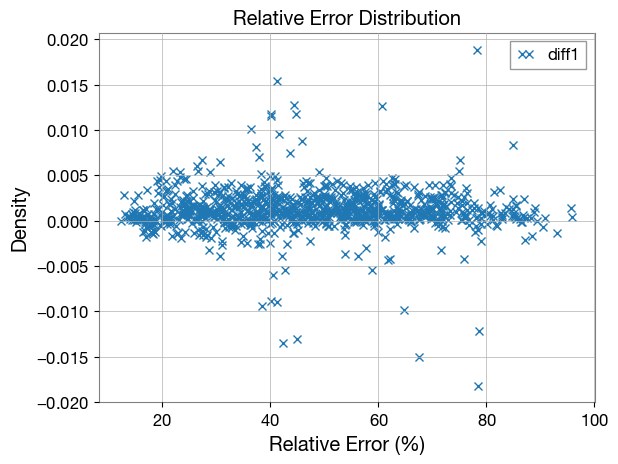

In [89]:
snr_true = snr_partial_true[0]* (Mchirp_scaled / dl_eff[0])  # scale by effective distance and chirp mass
snr_pred = snr_new * (Mchirp_scaled / dl_eff[0])  # scale by effective distance and chirp mass
idx = snr_true> 0
plt.plot(snr_true[idx], (snr_true[idx] - snr_pred[idx]), label='diff1', marker='x', linestyle='None', color='C0')
plt.xlabel('Relative Error (%)')
plt.ylabel('Density')
plt.title('Relative Error Distribution')
plt.legend()
# plt.xlim(0, 10)
plt.show()

In [77]:
idx_prb = abs(snr_true[idx] - snr_pred[idx])/ snr_true[idx]*100>1

In [78]:
mass_2_[idx][idx_prb], mass_1_[idx][idx_prb], a_1_[idx][idx_prb], a_2_[idx][idx_prb]

(array([3.33503121, 2.1163964 ]),
 array([5.37005757, 3.50502223]),
 array([-0.26325482,  0.05847464]),
 array([-0.37631515, -0.4909177 ]))

In [66]:
snr_true[idx].shape

(1000,)

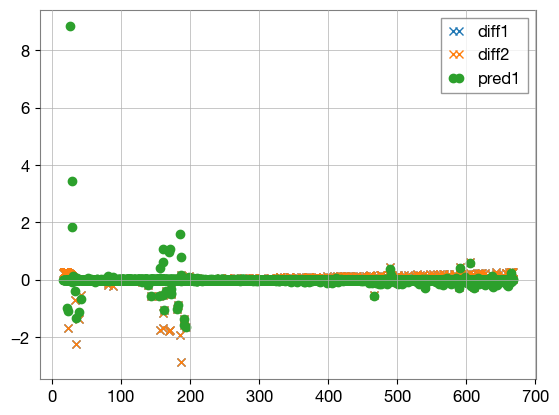

In [108]:
import matplotlib.pyplot as plt
snr_true = optimal_snr_unscaled['L1']
idx = snr_true> 0
plt.plot(snr_true[idx],snr_true[idx]-snr_pred1[idx], label='diff1', marker='x', linestyle='None', color='C0')
plt.plot(snr_true[idx],snr_true[idx]-snr_pred2[idx], label='diff2', marker='x', linestyle='None', color='C1')
plt.plot(snr_true[idx], snr_true[idx]-snr_pred3[idx], label='pred1', marker='o', linestyle='None', color='C2')
plt.legend()
plt.show()

In [44]:
idx_no = abs(snr_true[idx]-snr_batch[idx])>1
snr_true[idx][idx_no], snr_batch[idx][idx_no]

(array([1609.0088373 , 1130.62721984, 2830.24120997,
        2834.30848108, 2816.66420316, 2837.9980039 ,
        2808.26012532, 2838.7975963 , 2834.87381701,
        2831.80851502, 2810.54504652, 1536.15323049,
        2826.0876688 , 1710.51857877, 1145.07116205,
        2830.7712454 , 2787.98064342, 1270.49799518,
        1190.39652363, 2794.13600757, 2824.71821444,
        1317.34811655, 1163.3988352 ]),
 Array([1614.9395, 1132.0879, 2788.6804, 2803.6162, 2796.3408,
        2805.8687, 2806.6282, 2799.209 , 2796.3445, 2806.5635,
        2805.4143, 1550.6266, 2803.1323, 1713.3921, 1162.6875,
        2806.6282, 2928.6113, 1285.6229, 1193.2913, 2783.1853,
        2803.2961, 1323.7009, 1174.3912], dtype=float32))